In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
import matplotlib as mpl
import warnings

warnings.filterwarnings('ignore')
mpl.rcParams['savefig.dpi'] = 128
mpl.rcParams['figure.dpi'] = 128

df_fleats = pd.read_csv('marketing-breakdown-detailed.csv')
# df_loki =  pd.read_csv('enquiries_loki.csv')

# drop rows where contains any elements are nan
# df_fleats = df_fleats.dropna(axis=0, how='any')
# df_loki = df_loki.dropna(axis=0, how='any')

# df_enquiries = pd.merge(df_odin, df_loki, on=['Fleats Id'])
# remove undefined
# df_enquiries = df_enquiries[~df_enquiries['Applicant 1 Annual Salary'].isin(['undefined'])]
# df_enquiries = df_enquiries.drop('Fleats Id', 1)

# X = df_enquiries[['Marketing Code', 'Classification', 'Loan Amount']]
# X = df_enquiries.loc[:, df_enquiries.columns != 'Enquiry Status']

selected_features = ['Marketing Code','App Source', 'Web Source', 'Classification','Enquired',
                     'Loan Amount']
target = 'Enquiry Status';
whole_set = selected_features + [target]

data_set = df_fleats[whole_set]
data_set = data_set.replace('On Hold','Rejected')
data_set = data_set.dropna(axis=0, how='any')

In [2]:
from datetime import datetime
from dateutil.parser import parse

temp = pd.DatetimeIndex(data_set['Enquired'])
data_set['Enquired Date'] = pd.to_datetime(temp.date)
data_set['Enquired Time'] = temp.time
data_set = data_set.drop(['Enquired'],1)

# filter years
start_date = '2017-01-01' 
end_date = '2017-12-31'
mask = (data_set['Enquired Date'] > start_date) & (data_set['Enquired Date'] <= end_date)
data_set = data_set.loc[mask].reset_index(drop=True)

# X = data_set[['Marketing Code','App Source', 'Web Source', 'Classification','Enquired Date',]]
X = data_set[data_set.keys()]
X = X.drop(['Enquiry Status'],1)
y = data_set[target]

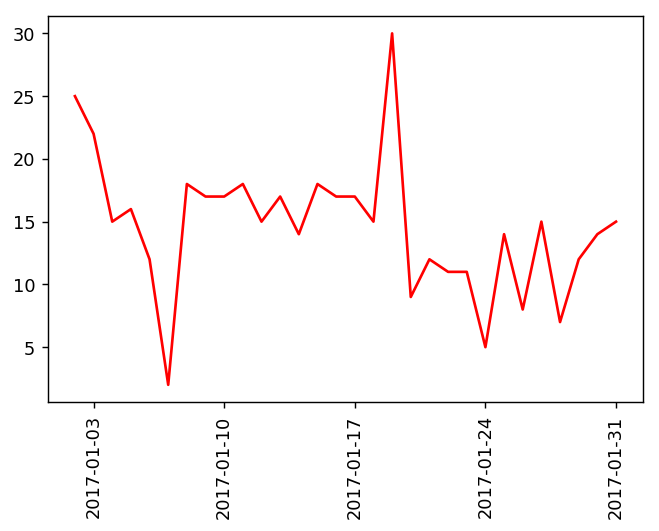

In [3]:
import random
import matplotlib.dates as mdates
import matplotlib.mlab as mlab

# generate some random data (approximately over 5 years)
data_1 = data_set[['Enquiry Status','Enquired Date']]
data_2 = data_set[['Enquiry Status','Enquired Time']]

plot_date = data_1.groupby(['Enquired Date', 'Enquiry Status']).size().reset_index(name="counts")
plot_date = plot_date.loc[plot_date['Enquiry Status'] == 'Accepted']

# plot_date
plt.plot_date(x=plot_date['Enquired Date'], y=plot_date['counts'],fmt="r-")
plt.xticks(rotation=90)
plt.show()

In [4]:
print("Keys of enquiries_dataset: \n{}".format(X.keys()))

Keys of enquiries_dataset: 
Index(['Marketing Code', 'App Source', 'Web Source', 'Classification',
       'Loan Amount', 'Enquired Date', 'Enquired Time'],
      dtype='object')


In [5]:
print("Shape of X: {}".format(X.shape))
print("Shape of y: {}".format(y.shape))

Shape of X: (3961, 7)
Shape of y: (3961,)


In [6]:
from sklearn.preprocessing import LabelEncoder

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [7]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
# Categorial feature ecoding
X = MultiColumnLabelEncoder(columns = X.keys()).fit_transform(X)
y = le.fit_transform(y)

In [8]:
# feature selection
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, y)
model = SelectFromModel(lsvc, prefit=True)
selected_X = model.transform(X)

# Get idxs of columns to keep
idxs_selected = model.get_support(indices=True)

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# split data and labels into a training and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
# rescale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
from sklearn.neighbors import KNeighborsClassifier

kn = KNeighborsClassifier(n_neighbors=3)
kn.fit(X_train_scaled, y_train)
pred_kn = kn.predict(X_test)
print("Test score: {:.2f}".format(kn.score(X_test_scaled, y_test)))

Test score: 0.90


In [11]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(loss="hinge", penalty="l2")
sgd.fit(X_train_scaled, y_train)
pred_sgd = sgd.predict(X_test)
print("Test score: {:.2f}".format(sgd.score(X_test_scaled, y_test)))

Test score: 0.84


In [12]:
from sklearn.kernel_approximation import RBFSampler

rbf_feature = RBFSampler(gamma=1, random_state=1)
X_features = rbf_feature.fit_transform(X_train_scaled)
clf = SGDClassifier()  
clf.fit(X_train_scaled, y_train)
print("Test score: {:.2f}".format(clf.score(X_test_scaled, y_test)))

Test score: 0.89


In [13]:
from sklearn import svm
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import cross_val_score

svc = svm.SVC()
svc.fit(X_train, y_train)
pred_svc = svc.predict(X_test)
print("Test score: {:.2f}".format(svc.score(X_test, y_test)))

# scores = cross_val_score(clf, X, y, cv=5)
# scores
# N = range(1, 16)
# for n in N:
#     pca = KernelPCA(n_components=n)
#     X_n_kept = pca.fit_transform(X_test_scaled)
#     # Estimate accuracy on the data set with top n components
#     classifier = svm.SVC(gamma=0.001)
#     score_n_components = cross_val_score(classifier, X_n_kept, y_test).mean()
#     print('Score with the data set of top {0} components: {1:.2f}'.format(n, score_n_components))

Test score: 0.89


In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics

rfc = RandomForestClassifier(n_estimators=500)
rfc.fit(X_train_scaled, y_train)
pred_forest = rfc.predict(X_test)

print("Test score: {:.2f}".format(rfc.score(X_test_scaled, y_test)))

scores = cross_val_score(rfc, X_test_scaled, y_test)
# print("Cross-validation scores: {}".format(scores.mean()))
# N = range(1, 100)
# best_score = 0
# n_estimators = 1
# for n in N:
#     rfc = RandomForestClassifier(n_estimators=n, n_jobs=-1)
#     rfc.fit(X_train_scaled, y_train)
#     score_n_components = cross_val_score(clf, X_test_scaled, y_test).mean()
#     if(best_score < score_n_components):
#         best_score = score_n_components
#         n_estimators = n
#     print('Score with the data set of top {0} components: {1:.2f}'.format(n, score_n_components))
# print('best socre is: {1:.2f} with {0} estimators'.format(best_score,n_estimators))

Test score: 0.91


 1) Loan Amount                    0.301803
 2) Enquired Time                  0.228889
 3) Marketing Code                 0.150605
 4) Enquired Date                  0.148399
 5) App Source                     0.087378
 6) Classification                 0.082926
 7) Web Source                     0.000000


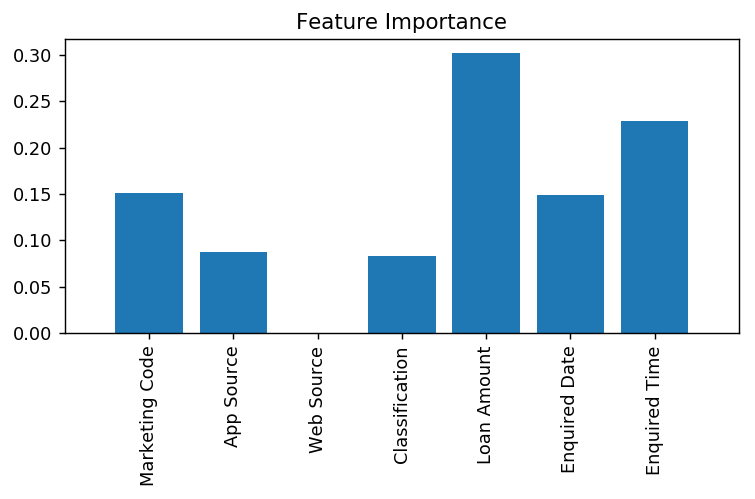

In [15]:
feat_labels = X.columns[:]
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))
    
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]),importances,align='center')
plt.xticks(range(X_train.shape[1]),feat_labels, rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

In [16]:
from sklearn.metrics import confusion_matrix

print("KNeighborsClassifier:")
print(confusion_matrix(y_test, pred_kn))
print("\nSGDClassifier:")
print(confusion_matrix(y_test, pred_sgd))
print("\nSVC:")
print(confusion_matrix(y_test, pred_svc))
print("\nRandomForestClassifier")
print(confusion_matrix(y_test, pred_forest))

KNeighborsClassifier:
[[   0  175]
 [   0 1410]]

SGDClassifier:
[[  40  135]
 [ 208 1202]]

SVC:
[[   0  175]
 [   0 1410]]

RandomForestClassifier
[[  68  107]
 [ 353 1057]]


In [17]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score

print("f1 score KNeighborsClassifier: {:.2f}".format(f1_score(y_test, pred_kn, average='weighted')))
print("f1 score SGDClassifier: {:.2f}".format(f1_score(y_test, pred_sgd,average='weighted')))
print("f1 score SVC: {:.2f}".format(f1_score(y_test, pred_svc,average='weighted')))
print("f1 score RandomForestClassifier: {:.2f}".format(f1_score(y_test, pred_forest,average='weighted')))
print()
print("precision score KNeighborsClassifier: {:.2f}".format(precision_score(y_test, pred_kn, average='weighted')))
print("precision score SGDClassifier: {:.2f}".format(precision_score(y_test, pred_sgd,average='weighted')))
print("precision score SVC: {:.2f}".format(precision_score(y_test, pred_svc,average='weighted')))
print("precision score RandomForestClassifier: {:.2f}".format(precision_score(y_test, pred_forest,average='weighted')))

f1 score KNeighborsClassifier: 0.84
f1 score SGDClassifier: 0.80
f1 score SVC: 0.84
f1 score RandomForestClassifier: 0.76

precision score KNeighborsClassifier: 0.79
precision score SGDClassifier: 0.82
precision score SVC: 0.79
precision score RandomForestClassifier: 0.83


In [18]:
# input_x = X.iloc[:]
# input_x_test = X.iloc[:,idxs_selected]
# # input_x = input_x.iloc[0,idxs_selected]

# # input_x = input_x.drop('Enquiry Status', 1)

# input_x_test = MultiColumnLabelEncoder(columns = input_x_test.keys()).fit_transform(input_x_test)
# input_x_test = scaler.fit_transform(input_x_test)

# # for row in input_x:
# #     result = rfc.predict(row)[0]
# #     proba = np.max(rfc.predict_proba(row))    

# #     print('reuslt: {}'.format(le.inverse_transform(result)))
# #     print('probability: {0}%'.format(proba))
# #     print()

# # result = rfc.predict(input_x)[0]
# # proba = np.max(rfc.predict_proba(input_x))    

# # print('reuslt: {}'.format(le.inverse_transform(result)))
# # print('probability: {0}%'.format(proba))
# result = rfc.predict(input_x_test)
# result = le.inverse_transform(result)
# proba = rfc.predict_proba(input_x_test)   
# proba = [np.max(p) for p in proba]
# input_x.to_csv('example.csv')

In [19]:
# input_x = input_x.assign(predict=result.tolist())
# input_x = input_x.assign(possibility=proba)
# input_x.head()
# input_x.to_csv('result/v1.csv')